In [317]:
#NOTE: Code developed with generative AI

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Data Displaying Making Prettier?
import json
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [318]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

# 1. Data loading

Working with 2 data sets, 1st is the initial and the 2nd is the expanded

In [319]:
from google.colab import drive
drive.mount('/content/drive')

import os, zipfile

# CHANGE THESE IF NEEDED
# Data Paths
SHARED_ROOT = "/content/drive/Shared drives/ECS171 Group project 9"
TAB_DATA  = os.path.join(SHARED_ROOT, "PreProcessed_data", "filtered_tab_data.xlsx")
UPDATED_TAB_DATA  = os.path.join(SHARED_ROOT, "PreProcessed_data", "updated tabular data - Sheet1.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [320]:
def dementiaScore(score):
  if (float(score) > 0): return 1
  return 0
def genderScore(gender):
  if (gender == "F"): return 1
  return 0

In [321]:
df_tab = pd.read_excel(TAB_DATA, sheet_name='Sheet1') # loading data from drive
df_tab.drop(columns=["Patient ID", "Hand", "ASF"], inplace=True) # ASF is a scaling factor, and data already normalized
df_tab["M/F"] = df_tab["M/F"].apply(genderScore)
df_tab["CDR"] = df_tab["CDR"].apply(dementiaScore)

tab_targets = tuple(df_tab["CDR"])
tab_features = list(df_tab.drop(columns=["CDR"]).columns)
print(tab_features)


['M/F', 'Age', 'Educ', 'SES', 'MMSE', 'eTIV', 'nWBV']


In [322]:
df_updated_tab = pd.read_csv(UPDATED_TAB_DATA, header=0) # loading data from drive, this one is a csv (compatability issues)
df_updated_tab.columns = [ col.replace('\xa0', ' ').strip() for col in df_updated_tab.columns ] # compatability issues...
df_updated_tab.drop(columns=["Patient ID", "ASF"], inplace=True) # Handedness already not included
df_updated_tab["M/F"] = df_updated_tab["M/F"].apply(genderScore)
df_updated_tab["CDR"] = df_updated_tab["CDR"].apply(dementiaScore)

updated_targets = tuple(df_updated_tab["CDR"])
updated_features = list(df_updated_tab.drop(columns=["CDR"]).columns)
print(updated_features)


['M/F', 'Age', 'Educ', 'SES', 'MMSE', 'eTIV', 'nWBV', 'csf_ml', 'gm_ml', 'wm_ml', 'brain_ml', 'csf_ratio', 'gm_ratio', 'wm_ratio', 'gm_wm_ratio']


# 2. Initial testing

In [323]:
### Testing with un-normalized data
# using 5-fold cross validation to better evaluate model performance on dataset
model = LogisticRegression(solver='liblinear')

# Initial Dataset:
print("# Results with initial dataset:")
X, y = df_tab[tab_features], pd.Series(tab_targets)
scores = cross_val_score(model, X, y, cv=5)
print(f"  Individual fold scores: {scores}")
print(f"  Mean accuracy: {np.mean(scores):.3f}")
print(f"  Standard deviation of accuracy: {np.std(scores):.3f}")

print("\n" + "="*50 + "\n")

# Expanded dataset
print("# Results with expanded dataset:")
X, y = df_updated_tab[updated_features], pd.Series(updated_targets)
scores = cross_val_score(model, X, y, cv=5)
print(f"  Individual fold scores: {scores}")
print(f"  Mean accuracy: {np.mean(scores):.3f}")
print(f"  Standard deviation of accuracy: {np.std(scores):.3f}")

# Results with initial dataset:
  Individual fold scores: [0.79069767 0.79069767 0.81395349 0.69767442 0.86046512]
  Mean accuracy: 0.791
  Standard deviation of accuracy: 0.053


# Results with expanded dataset:
  Individual fold scores: [0.88372093 0.79069767 0.90697674 0.69767442 0.8372093 ]
  Mean accuracy: 0.823
  Standard deviation of accuracy: 0.074


In [324]:
### Testing with normalized data
scaler = StandardScaler()
model = LogisticRegression(solver='liblinear')

# Initial Dataset:
print("# Results with initial dataset:")
X, y = df_tab[tab_features], pd.Series(tab_targets)
X_train_scaled = scaler.fit_transform(X)
# Below we add column names back on, helps for interpretability later
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns.tolist(), index=X.index)
scores = cross_val_score(model, X_train_scaled, y, cv=5)
print(f"  Individual fold scores: {scores}")
print(f"  Mean accuracy: {np.mean(scores):.3f}")
print(f"  Standard deviation of accuracy: {np.std(scores):.3f}")

print("\n" + "="*50 + "\n")

# Expanded dataset
print("# Results with expanded dataset:")
X, y = df_updated_tab[updated_features], pd.Series(updated_targets)
X_train_scaled = scaler.fit_transform(X)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns.tolist(), index=X.index)
scores = cross_val_score(model, X_train_scaled, y, cv=5)
print(f"  Individual fold scores: {scores}")
print(f"  Mean accuracy: {np.mean(scores):.3f}")
print(f"  Standard deviation of accuracy: {np.std(scores):.3f}")

# Results with initial dataset:
  Individual fold scores: [0.86046512 0.81395349 0.88372093 0.74418605 0.86046512]
  Mean accuracy: 0.833
  Standard deviation of accuracy: 0.050


# Results with expanded dataset:
  Individual fold scores: [0.86046512 0.79069767 0.90697674 0.69767442 0.86046512]
  Mean accuracy: 0.823
  Standard deviation of accuracy: 0.073


> Notes:
> 1) Normalization helps for smaller dataset, not significant for larger
> 2) Performance degrades on larger dataset. Investigated later.

> Moving on:
> Logistic regression is a good first choice, but how do other models perform?

In [325]:
print("Comparing Multiple Classification Models:\n")
print("# Results with initial dataset:")
X, y = df_tab[tab_features], pd.Series(tab_targets)
X_scaled = scaler.fit_transform(X)
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
    results[name] = {
        'mean_accuracy': np.mean(scores),
        'std_accuracy': np.std(scores),
        'scores': scores
    }
    print(f"  {name:20}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")


print("\n# Results with expanded dataset:")
X, y = df_updated_tab[updated_features], pd.Series(updated_targets)
X_scaled = scaler.fit_transform(X)
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
    results[name] = {
        'mean_accuracy': np.mean(scores),
        'std_accuracy': np.std(scores),
        'scores': scores
    }
    print(f"  {name:20}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")


Comparing Multiple Classification Models:

# Results with initial dataset:
  Logistic Regression : 0.833 ± 0.050
  Gradient Boosting   : 0.809 ± 0.034
  Random Forest       : 0.833 ± 0.040
  SVM                 : 0.791 ± 0.039
  Decision Tree       : 0.753 ± 0.041
  K-Nearest Neighbors : 0.763 ± 0.040

# Results with expanded dataset:
  Logistic Regression : 0.823 ± 0.073
  Gradient Boosting   : 0.795 ± 0.045
  Random Forest       : 0.823 ± 0.028
  SVM                 : 0.740 ± 0.045
  Decision Tree       : 0.767 ± 0.049
  K-Nearest Neighbors : 0.707 ± 0.048


> No model significantly better than logistic regression. Logistic regression continue with due to simplicity and interpretability.

# 3. Feature selection

Seeing our results, something isn't adding up. Why aren't more features helping our model learn?

> To investigate this, I analyze the weights of the logistic regression model. These models are very simple, and as a result, interpretable.

In [326]:
# From now on, only using expanded data set (for information on WHY it degrades)
# We investigate performance across many runs, to get a general sense of the model

model = LogisticRegression(solver='liblinear')
scaler = StandardScaler()

X, y = df_updated_tab[updated_features], pd.Series(updated_targets)
feature_names = X.columns.tolist()

n_runs = 150 # how many runs used to analyze results? More runs -> more accurate estimate
all_coefficients = []
all_accuracies = []

print(f"Running {n_runs} iterations with different shuffles...")
for i in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, shuffle=True, random_state=i
    )
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test) # no data leakage here
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index)

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    # recording model weights for analysis (and performance for fun)
    all_coefficients.append(model.coef_[0])
    all_accuracies.append(accuracy)

# Convert to arrays for easier analysis
all_coefficients = np.array(all_coefficients)
all_accuracies = np.array(all_accuracies)
final_mean_coef = all_coefficients.mean(axis=0)
final_std_coef = all_coefficients.std(axis=0)

print(f"\nAccuracy across {n_runs} runs: {all_accuracies.mean():.3f} ± {all_accuracies.std():.3f}\n")
results_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean_Weight': final_mean_coef,
    'Std_Dev': final_std_coef,
    'Abs_Weight': np.abs(final_mean_coef),
})
results_df = results_df.sort_values(by='Abs_Weight', ascending=False).reset_index(drop=True)
print("# Printing Results:")
print(results_df)


Running 150 iterations with different shuffles...

Accuracy across 150 runs: 0.833 ± 0.039

# Printing Results:
        Feature  Mean_Weight   Std_Dev  Abs_Weight
0          MMSE    -2.116712  0.196183    2.116712
1         gm_ml    -0.331996  0.047980    0.331996
2      brain_ml    -0.284210  0.032026    0.284210
3        csf_ml     0.281842  0.032153    0.281842
4          nWBV    -0.265015  0.058920    0.265015
5          eTIV     0.247590  0.157508    0.247590
6           Age    -0.231946  0.144564    0.231946
7     csf_ratio    -0.216410  0.147912    0.216410
8           SES     0.104012  0.152675    0.104012
9          Educ    -0.077925  0.149884    0.077925
10        wm_ml    -0.063624  0.056361    0.063624
11     gm_ratio    -0.056742  0.065572    0.056742
12     wm_ratio     0.056742  0.065572    0.056742
13  gm_wm_ratio    -0.044448  0.096135    0.044448
14          M/F    -0.039217  0.157612    0.039217


> Since our features are normalized, a larger magnitude of feature weight means that it has a larger importance to our models performance.

> We can see that **MMSE** (Mini-Mental State Examination) is the most important feature to our models decision.

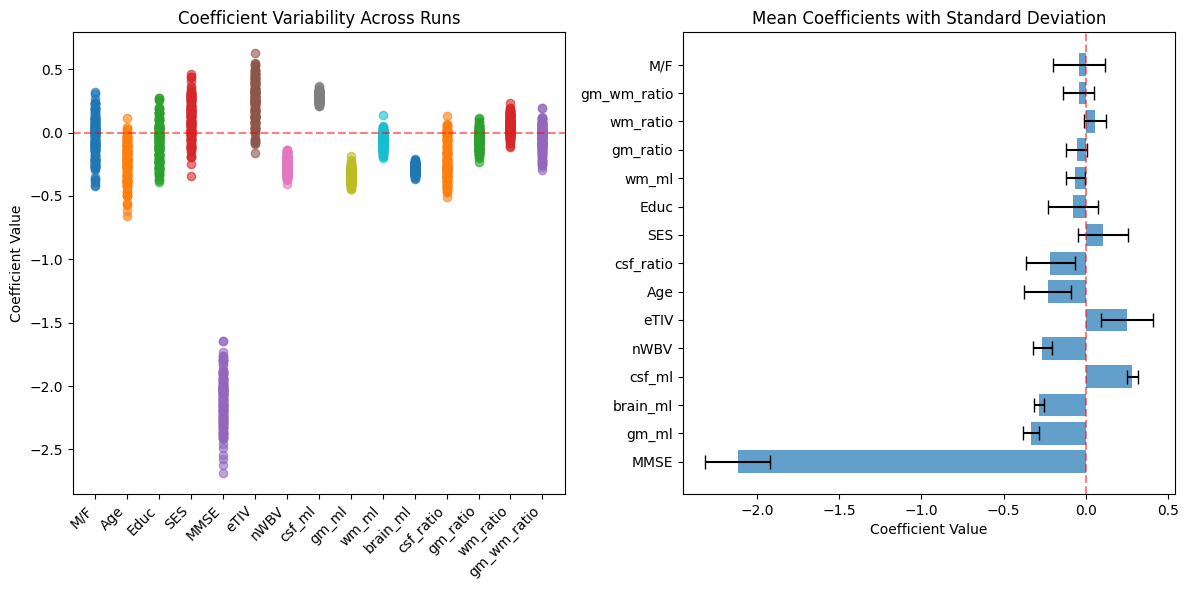

In [327]:
# Lets graph:
# LLM used for visualizations

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Coefficient distributions across runs
for i, feature in enumerate(feature_names):
    ax1.plot([i] * n_runs, all_coefficients[:, i], 'o', alpha=0.6, label=feature if i < 5 else "")

ax1.set_xticks(range(len(feature_names)))
ax1.set_xticklabels(feature_names, rotation=45, ha='right')
ax1.set_ylabel('Coefficient Value')
ax1.set_title('Coefficient Variability Across Runs')
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
if len(feature_names) <= 10:  # Only show legend if not too many features
    ax1.legend()

# Plot 2: Mean coefficients with error bars
ax2.barh(range(len(feature_names)), results_df['Mean_Weight'],
         xerr=results_df['Std_Dev'], capsize=5, alpha=0.7)
ax2.set_yticks(range(len(feature_names)))
ax2.set_yticklabels(results_df['Feature'])
ax2.set_xlabel('Coefficient Value')
ax2.set_title('Mean Coefficients with Standard Deviation')
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

> Visualizations of above results. MMSE is the most important feature, and many others are relatively unimportant in comparison.

> Let's test out how our model does with subsets of features

In [328]:
# Experimenting with keeping top k-features
model = LogisticRegression(solver='liblinear')
scaler = StandardScaler()

for k in range(1, len(updated_features)+1): # inclusive
  top_k_features = results_df['Feature'].head(k).tolist()
  X, y = df_updated_tab[top_k_features], pd.Series(updated_targets)
  X_train_scaled = scaler.fit_transform(X)
  X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns.tolist(), index=X.index)
  scores = cross_val_score(model, X_train_scaled, y, cv=5)
  print(f"{k:2} Features: Mean accuracy: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

 1 Features: Mean accuracy: 0.809 ± 0.023
 2 Features: Mean accuracy: 0.851 ± 0.038
 3 Features: Mean accuracy: 0.856 ± 0.031
 4 Features: Mean accuracy: 0.851 ± 0.024
 5 Features: Mean accuracy: 0.851 ± 0.024
 6 Features: Mean accuracy: 0.847 ± 0.043
 7 Features: Mean accuracy: 0.842 ± 0.040
 8 Features: Mean accuracy: 0.847 ± 0.035
 9 Features: Mean accuracy: 0.856 ± 0.037
10 Features: Mean accuracy: 0.833 ± 0.074
11 Features: Mean accuracy: 0.837 ± 0.066
12 Features: Mean accuracy: 0.837 ± 0.066
13 Features: Mean accuracy: 0.837 ± 0.066
14 Features: Mean accuracy: 0.837 ± 0.066
15 Features: Mean accuracy: 0.823 ± 0.073


> I will select top 4 features, good performance and tight bounds on variance.

> Retesting the various models on feature selected dataset:

In [329]:
for k in range(1, 5):
  top_k_features = results_df['Feature'].head(k).tolist()
  X, y = df_updated_tab[top_k_features], pd.Series(updated_targets)
  X_scaled = scaler.fit_transform(X)
  models = {
      'Logistic Regression': LogisticRegression(solver='liblinear'),
      'Gradient Boosting': GradientBoostingClassifier(random_state=42),
      'Random Forest': RandomForestClassifier(random_state=42),
      'SVM': SVC(random_state=42),
      'Decision Tree': DecisionTreeClassifier(random_state=42),
      'K-Nearest Neighbors': KNeighborsClassifier()
  }

  results = {}
  top_k_scores = []
  for name, model in models.items():
      scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
      results[name] = {
          'mean_accuracy': np.mean(scores),
          'std_accuracy': np.std(scores),
          'scores': scores
      }
      top_k_scores.append(np.mean(scores))
  print(f"# Results with top {k} feature dataset: - Average: {np.mean(top_k_scores):.3f}")
  for name, res in results.items(): # Use 'results' dictionary
      # Access the unique stored mean and std for the current model 'name'
      print(f"  {name:20}: {res['mean_accuracy']:.3f} ± {res['std_accuracy']:.3f}")

# Results with top 1 feature dataset: - Average: 0.832
  Logistic Regression : 0.809 ± 0.023
  Gradient Boosting   : 0.842 ± 0.017
  Random Forest       : 0.842 ± 0.017
  SVM                 : 0.823 ± 0.032
  Decision Tree       : 0.833 ± 0.027
  K-Nearest Neighbors : 0.842 ± 0.017
# Results with top 2 feature dataset: - Average: 0.811
  Logistic Regression : 0.851 ± 0.038
  Gradient Boosting   : 0.805 ± 0.032
  Random Forest       : 0.763 ± 0.068
  SVM                 : 0.860 ± 0.015
  Decision Tree       : 0.772 ± 0.047
  K-Nearest Neighbors : 0.814 ± 0.033
# Results with top 3 feature dataset: - Average: 0.819
  Logistic Regression : 0.856 ± 0.031
  Gradient Boosting   : 0.809 ± 0.040
  Random Forest       : 0.800 ± 0.024
  SVM                 : 0.847 ± 0.019
  Decision Tree       : 0.786 ± 0.054
  K-Nearest Neighbors : 0.819 ± 0.031
# Results with top 4 feature dataset: - Average: 0.819
  Logistic Regression : 0.851 ± 0.024
  Gradient Boosting   : 0.805 ± 0.041
  Random Forest     

> Logistic Regression continues to be our best model

# 4. Model optimization

Now that we have our optimized dataset, lets tune hyperparameters to achieve our final accuracy.

This step is prone to data leakage by optimizing hyperparameters for our test set, so we will not do that

In [330]:
# Setting the parameters for our grid search

param_grid = {
    'C': [0.1, 0.5, 1, 5, 10, 50, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1_weighted')

top_k_features = results_df['Feature'].head(5).tolist()
X, y = df_updated_tab[top_k_features], pd.Series(updated_targets)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=42
)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # no data leakage here
X_train_scaled = pd.DataFrame(X_train_scaled, columns=top_k_features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=top_k_features, index=X_test.index)

grid_search.fit(X_train_scaled, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV accuracy: {grid_search.best_score_:.3f}")

Best parameters: {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV accuracy: 0.853


In [331]:
best_params = grid_search.best_params_
model = LogisticRegression(C=best_params['C'], penalty=best_params['penalty'], solver=best_params['solver'])
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [332]:
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# 2. Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[37  5]
 [ 6 17]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        42
           1       0.77      0.74      0.76        23

    accuracy                           0.83        65
   macro avg       0.82      0.81      0.81        65
weighted avg       0.83      0.83      0.83        65



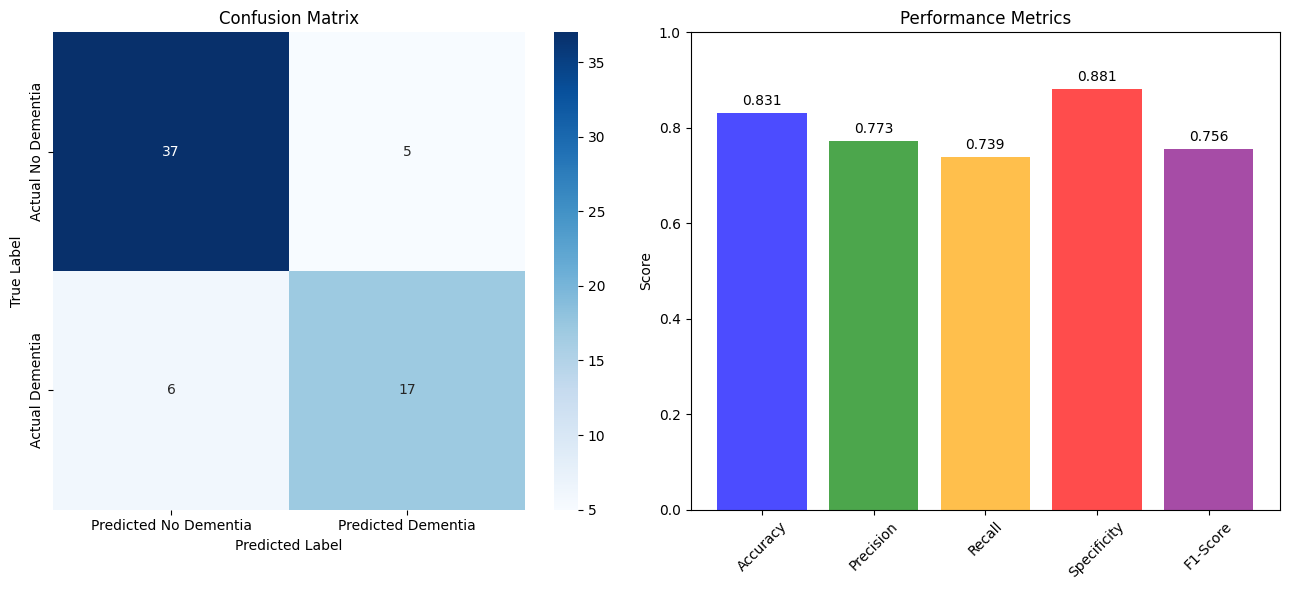

In [333]:
# Utilized LLM for visualization code

tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = 2 * (precision * recall) / (precision + recall)


plt.figure(figsize=(13, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No Dementia', 'Predicted Dementia'],
            yticklabels=['Actual No Dementia', 'Actual Dementia'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Plot 3: Metrics comparison
plt.subplot(1, 2, 2)
metrics = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score']
values = [accuracy, precision, recall, specificity, f1]
colors = ['blue', 'green', 'orange', 'red', 'purple']

bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.ylim(0, 1)
plt.title('Performance Metrics')
plt.xticks(rotation=45)
plt.ylabel('Score')

# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()



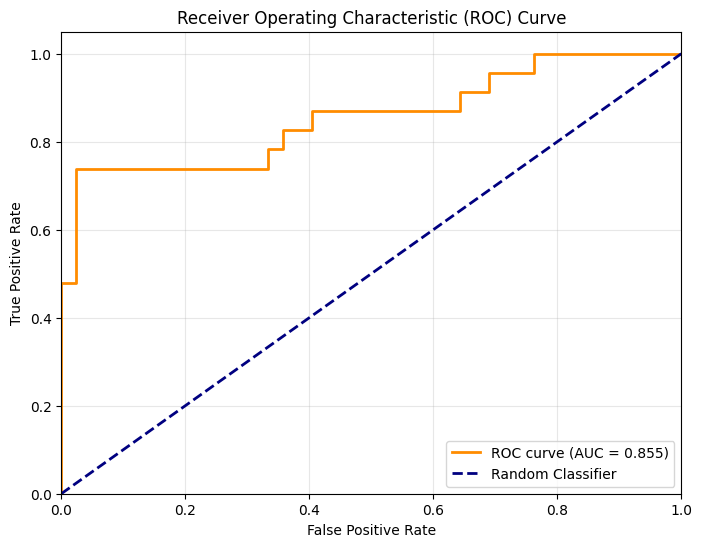


ROC AUC Score: 0.855


In [334]:
# Utilized LLM for visualization code

y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nROC AUC Score: {roc_auc:.3f}")